In [1]:
from PIL import Image
from numpy import asarray
import pickle
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import glob
import os
import cv2
import tensorflow as tf
from tensorflow import keras
import sys
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from google.colab import drive
from datetime import datetime, timedelta
drive.mount('/content/drive')
np.random.seed(7)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#train 데이터 전처리(LABELING)을 위한 코드
text = "root1_220823174615.jpg"
n = 7
result = text[6:n+11]
date_time = datetime.strptime(result, "%y%m%d%H%M%S")
formatted_date_time = date_time.strftime("%Y년 %m월 %d일 %H시 %M분 %S초")

output_list = []

for _ in range(6):
    delta = timedelta(minutes=720)

    # 시간 증가
    new_date_time = date_time + delta

    # 증가된 시간 출력
    formatted_date_time = new_date_time.strftime("%Y년 %m월 %d일 %H시 %M분 %S초")

    date_time = datetime.strptime(formatted_date_time, "%Y년 %m월 %d일 %H시 %M분 %S초")
    formatted_number = date_time.strftime("%y%m%d%H%M%S")

    output_list.append(int(formatted_number))

In [3]:
#test 데이터 전처리(LABELING)을 위한 코드
text = "root1_220923114836.jpg"
n = 7
result = text[6:n+11]
date_time = datetime.strptime(result, "%y%m%d%H%M%S")
formatted_date_time = date_time.strftime("%Y년 %m월 %d일 %H시 %M분 %S초")

test_output_list = []

for _ in range(6):
    delta = timedelta(minutes=720)

    # 시간 증가
    new_date_time = date_time + delta

    # 증가된 시간 출력
    formatted_date_time = new_date_time.strftime("%Y년 %m월 %d일 %H시 %M분 %S초")

    date_time = datetime.strptime(formatted_date_time, "%Y년 %m월 %d일 %H시 %M분 %S초")
    formatted_number = date_time.strftime("%y%m%d%H%M%S")


    test_output_list.append(int(formatted_number))

In [4]:
#train image google drive에서 load
image_directory = "/content/drive/MyDrive/root1_220823"

x_train = []
y_train = []

# Iterate over the files in the directory
for filename in os.listdir(image_directory):
    # Read the image
    image = cv2.imread(os.path.join(image_directory, filename))
    
    # Check if image is not empty
    if image is not None:
        # Resize the image to match the MNIST dataset size (32x32 pixels)
        try:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray_image  = gray_image[:, 80:-60] 
            gray_image = cv2.resize(gray_image, (32, 32))
 
            x_train.append(gray_image)
            text = filename
            n = 7
            result = text[6: n + 11]
            y_train.append(result)
        except Exception as e:
            print(f"Error processing image {filename}: {str(e)}")

# Convert the training data to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train=x_train.astype('float32')/255.0
x_train = x_train.reshape(x_train.shape[0], 32, 32, 1) #1채널 형태로 바꿔야함(data processing에서 중요)
input_shape = (32,32,1)

In [5]:
#test image google drive에서 load
image_directory = "/content/drive/MyDrive/root1_220923"

x_test = []
y_test = []

# Iterate over the files in the directory
for filename in os.listdir(image_directory):
    # Read the image
    image = cv2.imread(os.path.join(image_directory, filename))
    
    # Check if image is not empty
    if image is not None:
        # Resize the image to match the MNIST dataset size (32x32 pixels)
        try:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray_image = cv2.resize(gray_image, (32, 32))
            x_test.append(gray_image)
            text = filename
            n = 7
            result = text[6: n + 11]
            y_test.append(result)
        except Exception as e:
            print(f"Error processing image {filename}: {str(e)}")

# Convert the testing data to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

x_test = x_test.astype('float32')/255.0
x_test = x_test.reshape(x_test.shape[0], 32, 32, 1) #1채널 형태로 바꿔야함(data processing에서 중요)
input_shape = (32,32,1)

In [6]:
#train 데이터 catergorical labeling을 위해 one-hot encoding
Tmp=output_list

# Determine the class for each label
y_train_classes = []
for label in y_train:
    label=int(label)
    if label < Tmp[0]:
        class_index = 0
    elif Tmp[0] <= label < Tmp[1]:
        class_index = 1
    elif Tmp[1] <= label < Tmp[2]:
        class_index = 2
    elif Tmp[2] <= label < Tmp[3]:
        class_index = 3
    elif Tmp[3] <= label < Tmp[4]:
        class_index = 4
    elif Tmp[4] <= label < Tmp[5]:
        class_index = 5
    else:
        class_index = 6
    y_train_classes.append(class_index)

# Convert the class labels to one-hot encoded vectors
num_classes = len(Tmp) + 1
y_train_one_hot = keras.utils.to_categorical(y_train_classes, num_classes)

In [7]:
#test 데이터 catergorical labeling을 위해 one-hot encoding
t_Tmp= test_output_list

# Determine the class for each label
y_test_classes = []

for label in y_test:
    label=int(label)
    if label < t_Tmp[0]:
        class_index = 0
    elif t_Tmp[0] <= label < t_Tmp[1]:
        class_index = 1
    elif t_Tmp[1] <= label < t_Tmp[2]:
        class_index = 2
    elif t_Tmp[2] <= label < t_Tmp[3]:
        class_index = 3
    elif t_Tmp[3] <= label < t_Tmp[4]:
        class_index = 4
    elif t_Tmp[4] <= label < t_Tmp[5]:
        class_index = 5
    else:
        class_index = 6        
    y_test_classes.append(class_index)

# Convert the class labels to one-hot encoded vectors
num_classes = len(t_Tmp) + 1
y_test_one_hot = keras.utils.to_categorical(y_test_classes, num_classes)

In [8]:
#cnn model
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same',activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (2, 2), activation='relu', padding='same')) #64채널에 
model.add(MaxPooling2D(pool_size=(2, 2))) #특징들의 확률을 확실히 정함
model.add(Dropout(0.25)) #트레인 튜런중 일부를 꺼서 오버피팅 막음
model.add(Flatten())  #각 레이어를 통해 추출된 특징들을 2차원에서 1차원으로 바꿔 fully connected layer에 들어가기 전 바꾼다
model.add(Dense(1000, activation='relu')) #입력받는 노드들과 출력으로 나가는 노드들의 개수를 받아 연결한다
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [9]:
#train 데이터를 fitting
batch_size = 16
epochs = 50

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist_train = model.fit(x_train, y_train_one_hot, batch_size=batch_size, epochs=epochs,verbose=1)

Epoch 1/50
36/36 [==============================] - 7s 11ms/step - loss: 1.0527 - accuracy: 0.6303
Epoch 2/50
36/36 [==============================] - 0s 8ms/step - loss: 0.6680 - accuracy: 0.7394
Epoch 3/50
36/36 [==============================] - 0s 8ms/step - loss: 0.5158 - accuracy: 0.8116
Epoch 4/50
36/36 [==============================] - 0s 7ms/step - loss: 0.3840 - accuracy: 0.8820
Epoch 5/50
36/36 [==============================] - 0s 8ms/step - loss: 0.3586 - accuracy: 0.8732
Epoch 6/50
36/36 [==============================] - 0s 9ms/step - loss: 0.2761 - accuracy: 0.8996
Epoch 7/50
36/36 [==============================] - 1s 18ms/step - loss: 0.2064 - accuracy: 0.9225
Epoch 8/50
36/36 [==============================] - 0s 7ms/step - loss: 0.2202 - accuracy: 0.9225
Epoch 9/50
36/36 [==============================] - 0s 5ms/step - loss: 0.1702 - accuracy: 0.9419
Epoch 10/50
36/36 [==============================] - 0s 5ms/step - loss: 0.1781 - accuracy: 0.9384
Epoch 11/50
36/36

18/18 [==============================] - 0s 5ms/step


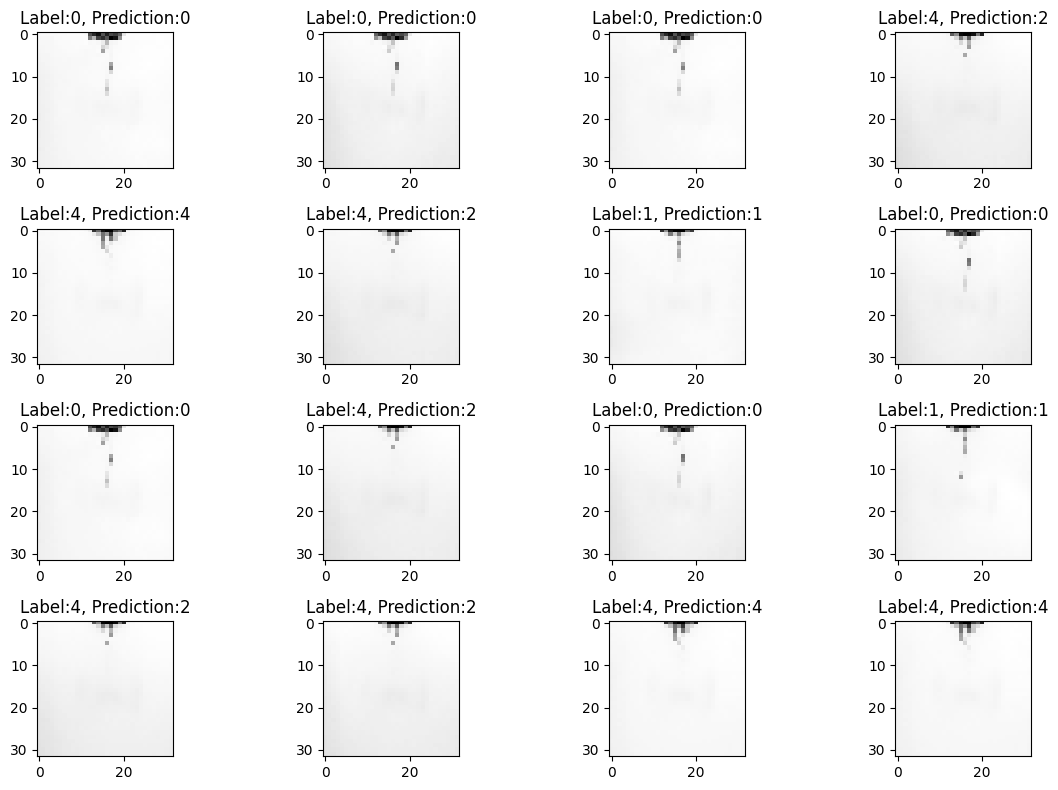

In [10]:
#fitting된 모델로 train_data 예측 실시
predicted_result = model.predict(x_train)
predicted_labels = np.argmax(predicted_result, axis=1)

test_labels = np.argmax(y_train_one_hot, axis=1)
wrong_result = []

for n in range(0, len(test_labels)):
    if predicted_labels[n] != test_labels[n]:
        wrong_result.append(n)
  
samples = random.choices(population=wrong_result, k=16)
count = 0
nrows = ncols = 4
plt.figure(figsize=(12,8))

for n in samples:
    count += 1
    plt.subplot(nrows, ncols, count)
    plt.imshow(x_train[n], cmap='Greys', interpolation='nearest')
    tmp = "Label:" + str(test_labels[n]) + ", Prediction:" + str(predicted_labels[n]-1)
    plt.title(tmp)

plt.tight_layout()
plt.show()

16/16 [==============================] - 0s 7ms/step


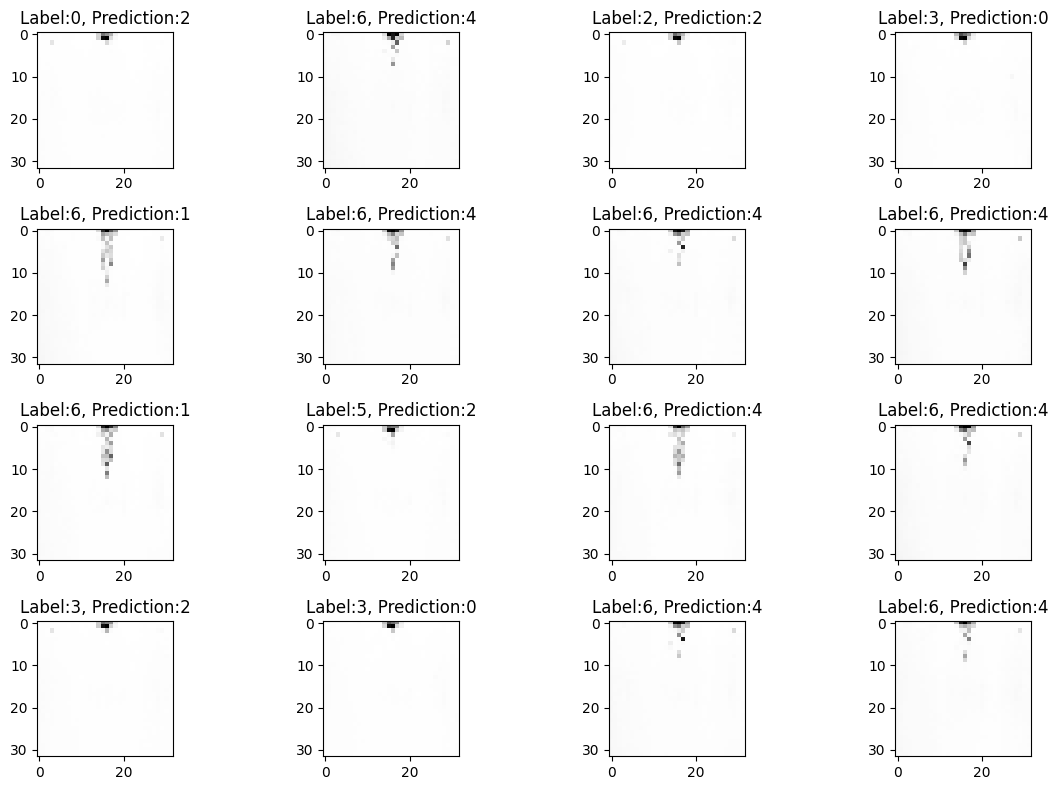

In [11]:
#fitting된 모델로 test_data 예측 실시
random_numbers = random.sample(range(501), 16)  # Select 15 random numbers from 0 to 500

predicted_result = model.predict(x_test)
predicted_labels = np.argmax(predicted_result, axis=1)

test_labels = np.argmax(y_test_one_hot, axis=1)
wrong_result = []

for n in range(0, len(test_labels)):
    if predicted_labels[n] != test_labels[n]:
        wrong_result.append(n)
  
count = 0
nrows = ncols = 4
plt.figure(figsize=(12,8))

for n in random_numbers:
    count += 1
    plt.subplot(nrows, ncols, count)
    plt.imshow(x_test[n], cmap='Greys', interpolation='nearest')
    tmp = "Label:" + str(test_labels[n]) + ", Prediction:" + str(predicted_labels[n])
    plt.title(tmp)

plt.tight_layout()
plt.show()

In [12]:
#model에 따라 train, test별 history graph를 위한 모델 재설정 후 fitting
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same',activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (2, 2), activation='relu', padding='same')) #64채널에 
model.add(MaxPooling2D(pool_size=(2, 2))) #특징들의 확률을 확실히 정함
model.add(Dropout(0.25)) #트레인 튜런중 일부를 꺼서 오버피팅 막음
model.add(Flatten())  #각 레이어를 통해 추출된 특징들을 2차원에서 1차원으로 바꿔 fully connected layer에 들어가기 전 바꾼다
model.add(Dense(1000, activation='relu')) #입력받는 노드들과 출력으로 나가는 노드들의 개수를 받아 연결한다
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
batch_size = 16
epochs = 50

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist_test = model.fit(x_train, y_train_one_hot, batch_size=batch_size, epochs=epochs,verbose=1)

Epoch 1/50
36/36 [==============================] - 2s 5ms/step - loss: 1.0193 - accuracy: 0.6215
Epoch 2/50
36/36 [==============================] - 0s 5ms/step - loss: 0.6581 - accuracy: 0.7465
Epoch 3/50
36/36 [==============================] - 0s 5ms/step - loss: 0.5004 - accuracy: 0.8257
Epoch 4/50
36/36 [==============================] - 0s 5ms/step - loss: 0.3407 - accuracy: 0.8820
Epoch 5/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2853 - accuracy: 0.8908
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 0.2465 - accuracy: 0.9085
Epoch 7/50
36/36 [==============================] - 0s 5ms/step - loss: 0.2156 - accuracy: 0.9173
Epoch 8/50
36/36 [==============================] - 0s 4ms/step - loss: 0.2092 - accuracy: 0.9225
Epoch 9/50
36/36 [==============================] - 0s 4ms/step - loss: 0.1869 - accuracy: 0.9331
Epoch 10/50
36/36 [==============================] - 0s 4ms/step - loss: 0.1669 - accuracy: 0.9454
Epoch 11/50
36/36 [

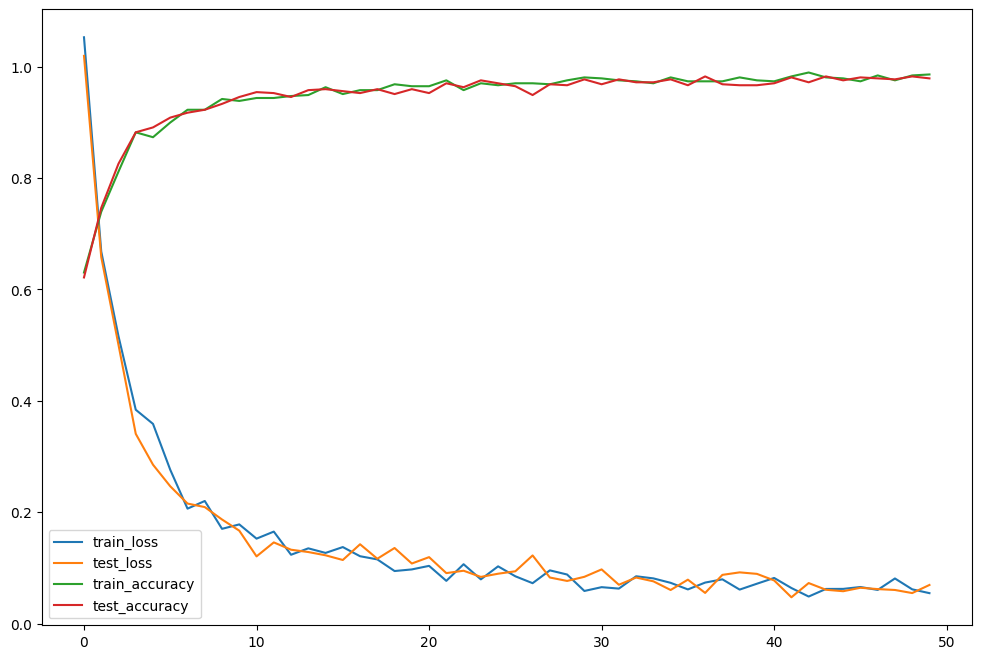

In [13]:
#hist graph plotting
combined_hist = {}
combined_hist['train_loss'] = hist_train.history['loss']
combined_hist['test_loss'] = hist_test.history['loss']
combined_hist['train_accuracy'] = hist_train.history['accuracy']
combined_hist['test_accuracy'] = hist_test.history['accuracy']

plt.figure(figsize=(12, 8))
plt.plot(combined_hist['train_loss'])
plt.plot(combined_hist['test_loss'])
plt.plot(combined_hist['train_accuracy'])
plt.plot(combined_hist['test_accuracy'])
plt.legend(['train_loss', 'test_loss', 'train_accuracy', 'test_accuracy'])
plt.show()